# Evaluation notebook
## Dependencies

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import utilities as utils
from siameseDataloader import readDataFolder, SiameseDataset, MyImagenetDataset
from siameseModel import SimpleSiameseNetwork, Resnet20Siamese, Resnet20Binary, MobileNetSiamese, MobilenetBinary

In [94]:
config = utils.load_config()
numclasses = config['DATASET']['numclasses']
im_size = config['DATASET']['im_size']
emb_size=config['MODEL']['embsize']

seed = config['seed']
np.random.seed(seed)

device = config['TRAIN']['device']

In [95]:
mode = 4

## Prepare evaluation datasets

### Separate val set images into folders

In [75]:
'''
dataset_dir = os.path.join('data','tiny-imagenet-200-copy')
val_dir = os.path.join(dataset_dir, 'val')
img_dir = os.path.join(val_dir, 'images')

fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
data = fp.readlines()
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Create folder if not present and move images into proper folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(img_dir, img)):
        os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))
'''

"\ndataset_dir = os.path.join('data','tiny-imagenet-200-copy')\nval_dir = os.path.join(dataset_dir, 'val')\nimg_dir = os.path.join(val_dir, 'images')\n\nfp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')\ndata = fp.readlines()\nval_img_dict = {}\nfor line in data:\n    words = line.split('\t')\n    val_img_dict[words[0]] = words[1]\nfp.close()\n\n# Create folder if not present and move images into proper folders\nfor img, folder in val_img_dict.items():\n    newpath = (os.path.join(img_dir, folder))\n    if not os.path.exists(newpath):\n        os.makedirs(newpath)\n    if os.path.exists(os.path.join(img_dir, img)):\n        os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))\n"

### Read test datasets

In [96]:
datadir = os.path.join('data','tiny-imagenet-200-copy','val','images')
seen_dataset = readDataFolder(datadir,numclasses,seen=True)
unseen_dataset = readDataFolder(datadir,numclasses,seen=False)
all_dataset = readDataFolder(datadir,200)
val_dataset = torch.load('val_dataset.pkl')
val_dataset_64 = torch.load('val_dataset_64.pkl')

We consider three different evaluation cases:
1. Performance on seen classes
2. Performance on unseen classes
3. Combined performance on all 200 classes

In [97]:
test_transforms = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])

In [98]:
if mode == 1:
    siamese_dataset = SiameseDataset(seen_dataset, transform=test_transforms , sameprob=0.5, issplit=False)
    dataset = MyImagenetDataset(seen_dataset,transform=test_transforms,issplit=False)
    numclassesreal = numclasses
elif mode==2:
    siamese_dataset = SiameseDataset(unseen_dataset, transform=test_transforms , sameprob=0.5, issplit=False)
    dataset = MyImagenetDataset(unseen_dataset,transform=test_transforms,issplit=False)
    numclassesreal = 200 - numclasses
elif mode==3:
    siamese_dataset = SiameseDataset(all_dataset, transform=test_transforms , sameprob=0.5, issplit=False)
    dataset = MyImagenetDataset(all_dataset,transform=test_transforms,issplit=False)
    numclassesreal = 200
elif mode==4:
    siamese_dataset = val_dataset
    numclassesreal=numclasses
else:
    siamese_dataset = val_dataset_64
    numclassesreal=numclasses

In [99]:
dataloader = DataLoader(siamese_dataset,shuffle=False, 
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize'])

In [100]:
for i,data in enumerate(dataloader):
    print(data[0].shape)
    break

torch.Size([64, 3, 32, 32])


## Model

In [101]:
if config['MODEL']['model'] == 'simple':
    model = SimpleSiameseNetwork(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='resnet':
    model = Resnet20Siamese(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='mobilenet':
    model = MobileNetSiamese(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='mobilenetbinary':
    model = MobilenetBinary(pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='resnetbinary':
    model = Resnet20Binary(pretrained=config['MODEL']['pretrained'],embsize=emb_size)
else:
    model = SimpleSiameseNetwork(config['MODEL']['distance'],embsize=emb_size)
    
model.eval()

Using cache found in C:\Users\Emilija/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


MobileNetSiamese(
  (distance): PairwiseDistance()
  (network): MobileNet(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Seque

## Extract embeddings

In [105]:
embs = []
emb_labels = []

In [106]:
model = model.to(device)
for k in range(5):
    for i,(img1,img2,label) in enumerate(dataloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        with torch.no_grad():
            out = model.getEmb(img1,img2)

        embs+=out.tolist()
        emb_labels+=label.detach().tolist()

In [107]:
modelname = "saved\\"+config['MODEL']['model']+'_sameprob025_'
torch.save((embs,emb_labels),modelname+'embs.pkl')

## Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

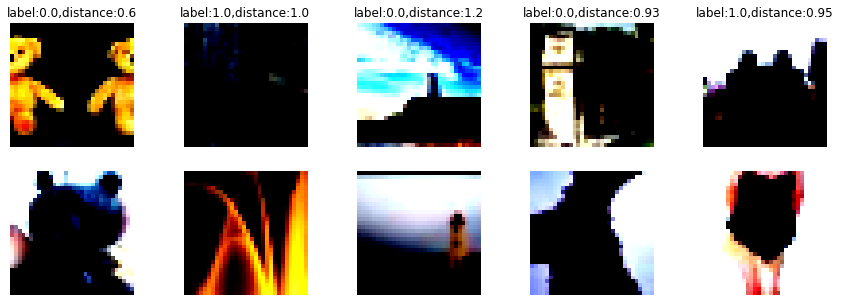

In [28]:
# Visualise
model =model.to('cpu')
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    ind = np.random.randint(0,len(siamese_dataset))
    example = siamese_dataset[ind]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,im_size,im_size),example[1].reshape(1,3,im_size,im_size))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

## Train and evaluate embs

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt

X_train, y_train = torch.load('saved\\mobilenet_trainembs.pkl')
X_val,y_val = torch.load('saved\\mobilenet_valembs.pkl')

X_train = np.array(X_train)
y_train =np.array(y_train).ravel()
X_val = np.array(X_val)
y_val = np.array(y_val).ravel()

In [35]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=0.01)

In [36]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=0.01)

In [37]:
prediction_train = clf.predict(X_train)
prediction_val = clf.predict(X_val)

In [67]:
acc_train = np.sum(prediction_train == y_train)/len(y_train)
acc_val = np.sum(prediction_val == y_val)/len(y_val)
print(acc_train,acc_val)

0.872475 0.79188


In [68]:
torch.save(clf,'models\\mobilenet_MLP.pkl')

In [78]:
out = clf.predict_proba(X_val)[:,1]
config['TRAIN']['lossmargin'] = 1/1.2
config['MODEL']['model'] = 'mobilenet_emb'

In [79]:
threshs= np.linspace(0,1,11)
accs = []
sensitivity = []
specificity = []
f1 = []
precision = []
label = y_val
for thresh in threshs:
    conf = np.zeros((2,2))
    conf[1,1] = np.matmul(label.T,(out>=thresh)*1)
    conf[1,0] = np.matmul(label.T,(out<thresh)*1)
    conf[0,1] = np.matmul((1-label).T,(out>=thresh)*1)
    conf[0,0] = np.matmul((1-label).T,(out<thresh)*1)
    pos = np.sum(label)
    neg = np.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)))
    sensitivity.append((conf[0,0]/neg)) 
    specificity.append((conf[1,1]/pos))
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])))
    precision.append((conf[0,0]/(conf[0,0]+conf[1,0])).item())
    

C:\Users\Emilija\AppData\Local\Temp\ipykernel_15556\3865665546.py:21: RuntimeWarning: invalid value encountered in double_scalars
  precision.append((conf[0,0]/(conf[0,0]+conf[1,0])).item())


In [80]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
precision = np.array(precision)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

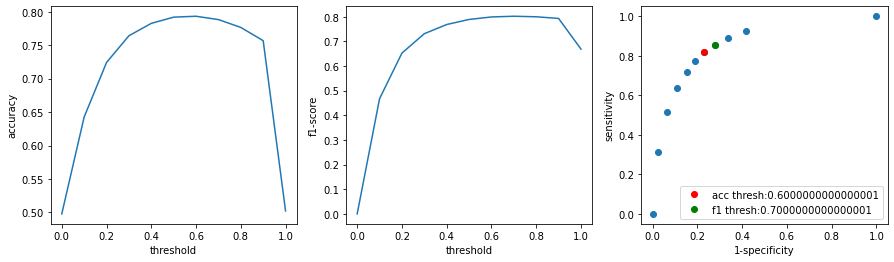

In [81]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

In [82]:
name = "saved\\"+config['MODEL']['model']+"_"
torch.save(threshs,name+'threshs.pkl')
torch.save(accs,name+'accs.pkl')
torch.save(f1,name+'f1.pkl')
torch.save(specificity,name+'specificity.pkl')
torch.save(sensitivity,name+'sensitivity.pkl')
torch.save(precision,name+'precision.pkl')

## Test embs

In [123]:
import numpy as np
import torch
import matplotlib.pyplot as plt

X_test, y_test = torch.load('saved\\mobilenet_seen_embs.pkl')
clf = torch.load('models\\mobilenet_MLP.pkl')


In [124]:
prediction_test = clf.predict(X_test)
acc_test = np.sum(prediction_test == np.array(y_test).T[0])/len(y_test)
print(acc_test)

out = clf.predict_proba(X_test)[:,1]

0.8052


In [125]:
threshs= np.linspace(0,1,11)
accs = []
sensitivity = []
specificity = []
f1 = []
precision = []
label = np.array(y_test).T[0]
for thresh in threshs:
    conf = np.zeros((2,2))
    conf[1,1] = np.matmul(label.T,(out>=thresh)*1)
    conf[1,0] = np.matmul(label.T,(out<thresh)*1)
    conf[0,1] = np.matmul((1-label).T,(out>=thresh)*1)
    conf[0,0] = np.matmul((1-label).T,(out<thresh)*1)
    pos = np.sum(label)
    neg = np.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)))
    sensitivity.append((conf[0,0]/neg)) 
    specificity.append((conf[1,1]/pos))
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])))
    precision.append((conf[0,0]/(conf[0,0]+conf[1,0])).item())
    

C:\Users\Emilija\AppData\Local\Temp\ipykernel_22624\3008433344.py:21: RuntimeWarning: invalid value encountered in double_scalars
  precision.append((conf[0,0]/(conf[0,0]+conf[1,0])).item())


In [126]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
precision = np.array(precision)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

Text(0.5, 1.0, '(c)')

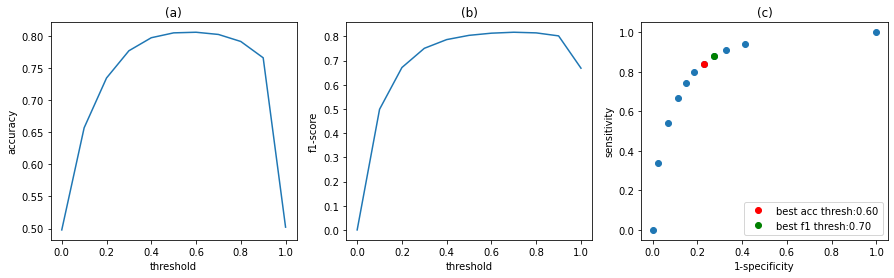

In [129]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[0].set_title('(a)')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[1].set_title('(b)')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='best acc thresh:{:.2f}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='best f1 thresh:{:.2f}'.format(threshs[m2]))
ax[2].legend()
ax[2].set_title('(c)')

In [113]:
name = "saved\\"+config['MODEL']['model']+"_sameprob025_"
torch.save(threshs,name+'threshs.pkl')
torch.save(accs,name+'accs.pkl')
torch.save(f1,name+'f1.pkl')
torch.save(specificity,name+'specificity.pkl')
torch.save(sensitivity,name+'sensitivity.pkl')
torch.save(precision,name+'precision.pkl')

## Evaluation - acc, f1,...

In [40]:
model.eval()
model=model.to(device)
#threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=11)
threshs = np.linspace(start=0,stop=1,num=11)
#threshs = [config['TRAIN']['lossmargin']/2]
#threshs=[0.5]
accs = []
sensitivity = []
specificity = []
precision = []
f1=[]

for k in range(5):
    accs.append([])
    sensitivity.append([])
    specificity.append([])
    precision.append([])
    f1.append([])
    
    for thresh in threshs:
        pos=0
        neg=0
        conf = np.zeros((2,2))
    
        for i,(img1,img2,label) in enumerate(dataloader):
            img1=img1.to(device)
            img2=img2.to(device)
            label=label.to(device)
            with torch.no_grad():
                out = model(img1,img2)
            
            conf[1,1] += torch.matmul(label.T*1.,(out>=thresh)*1.)
            conf[1,0] += torch.matmul(label.T*1.,(out<thresh)*1.)
            conf[0,1] += torch.matmul((1-label).T*1.,(out>=thresh)*1.)
            conf[0,0] += torch.matmul((1-label).T*1.,(out<thresh)*1.)
            pos = pos + torch.sum(label)
            neg = neg + torch.sum(1-label)

        accs[k].append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
        sensitivity[k].append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
        specificity[k].append((conf[1,1]/pos).item())
        precision[k].append((conf[0,0]/(conf[0,0]+conf[1,0])).item())
        f1[k].append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())
    

C:\Users\Emilija\AppData\Local\Temp\ipykernel_15556\3225088568.py:42: RuntimeWarning: invalid value encountered in double_scalars
  precision[k].append((conf[0,0]/(conf[0,0]+conf[1,0])).item())


KeyboardInterrupt: 

In [ ]:
accs = np.array(accs).mean(axis=0)
sensitivity = np.array(sensitivity).mean(axis=0)
specificity = np.array(specificity).mean(axis=0)
precision = np.array(precision).mean(axis=0)
f1 = np.array(f1).mean(axis=0)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

In [ ]:
print(accs)
print(f1)

[0.50368001 0.51573334 0.53573333 0.55984001 0.57832001 0.57717333
 0.56373334 0.54106668 0.52176001 0.50522668 0.50210667]
[0.         0.05297721 0.1725009  0.35898352 0.50796691 0.59296482
 0.64087358 0.65924508 0.66945744 0.66747864 0.66821566]


In [15]:
#name = "saved\\"+config['MODEL']['model']+"_"
#threshs = torch.load(name+'threshs.pkl')
#accs = torch.load(name+'accs.pkl')
#f1 = torch.load(name+'f1.pkl')
#specificity = torch.load(name+'specificity.pkl')
#sensitivity = torch.load(name+'sensitivity.pkl')

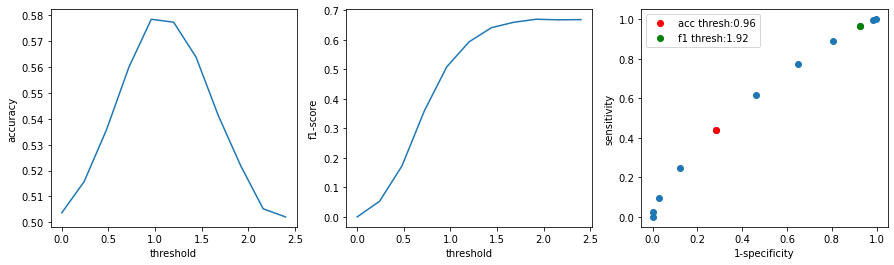

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

In [63]:
name = "saved\\"+config['MODEL']['model']+"_emb_"
torch.save(threshs,name+'threshs.pkl')
torch.save(accs,name+'accs.pkl')
torch.save(f1,name+'f1.pkl')
torch.save(specificity,name+'specificity.pkl')
torch.save(sensitivity,name+'sensitivity.pkl')
torch.save(precision,name+'precision.pkl')

## Average distance

In [18]:
dl = DataLoader(dataset,batch_size=50,shuffle=False)

In [19]:
classes = []
for i,(imgs,labels) in enumerate(dl):
    classes.append(imgs)

In [20]:
i=0
batch = torch.concat((classes[i],classes[i][1:],classes[i][0].reshape((1,3,im_size,im_size)),classes[i][2:],classes[i][:2]),dim=0)

In [21]:
batch.shape

torch.Size([150, 3, 32, 32])

In [22]:
# compare 100 imgs
avg_distance = np.zeros((numclassesreal,numclassesreal))
for i in range(numclassesreal):
    print(i)
    for j in range(i,numclassesreal):
        batchi = torch.concat((classes[i],classes[i][1:],classes[i][0].reshape((1,3,im_size,im_size)),classes[i][2:],classes[i][:2]),dim=0)
        batchj = torch.concat((classes[j],classes[j][1:],classes[j][0].reshape((1,3,im_size,im_size)),classes[j][2:],classes[j][:2]),dim=0)
        batchi = batchi.to(device)
        batchj = batchj.to(device)
        
        dist = model(batchi,batchj)
        avg_distance[i,j] = dist.mean().item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [23]:
torch.save(avg_distance, name+"distance_all.pkl")

### Analyse distances

In [324]:
avg_distance = torch.load('saved\\mobilenet_testall_distance_all.pkl')
n = avg_distance.shape[0]
inds = np.tri(n, k=-1, dtype=np.bool)
avg_distance[inds] = avg_distance.T[inds]

avg_distance = avg_distance[np.arange(50)][:,np.arange(50)]

C:\Users\Emilija\AppData\Local\Temp\ipykernel_22624\3317096056.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inds = np.tri(n, k=-1, dtype=np.bool)


In [218]:
avg_distance[130,125]

1.191629409790039

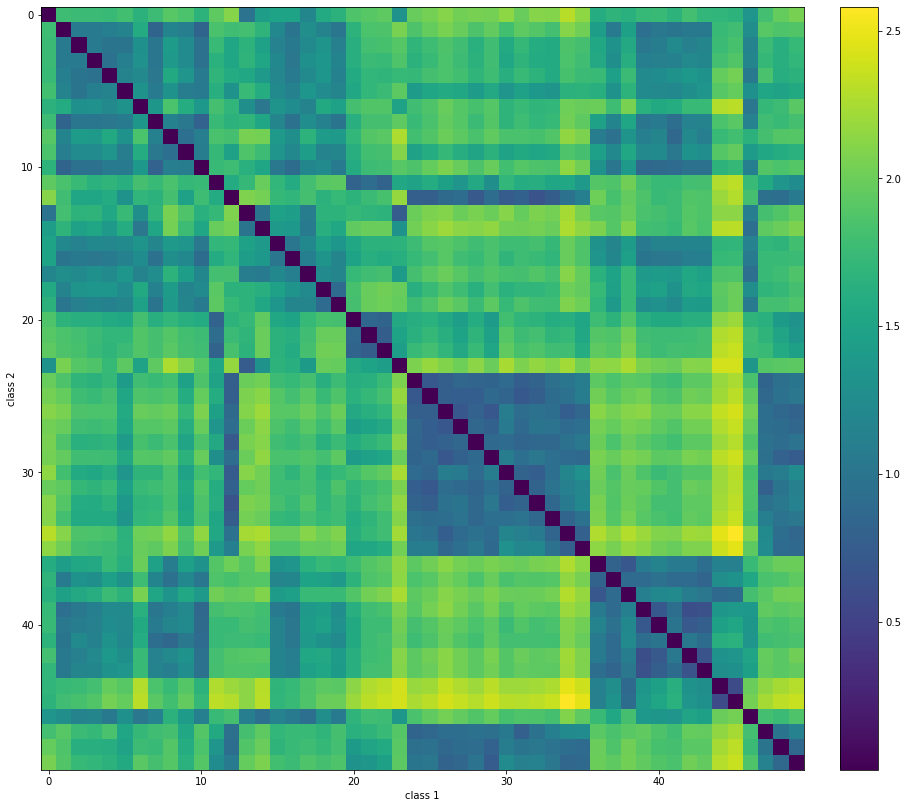

In [246]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(1,1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
im = ax.matshow(avg_distance)
ax.xaxis.tick_bottom()
ax.set_xlabel('class 1')
ax.set_ylabel('class 2')
fig.colorbar(im,cax=cax, orientation='vertical')


In [328]:
avg_distance = torch.load('saved\\mobilenet_testall_distance_all.pkl')
dist = avg_distance.copy()
dist[np.arange(dist.shape[0]),np.arange(dist.shape[1])] = 10000
dist[np.where(dist==0)] = 10000
k=10
numclasses = avg_distance.shape[0]
inds = np.argpartition(avg_distance,k,axis=None)[:k]
ind1 = inds//numclasses
ind2 = inds%numclasses

print(ind1)
print(ind2)
similar = dist[ind1,ind2]
pairs = [str(ind1[i])+" & "+str(ind2[i]) for i in range(len(ind1))]

[133 133 133 133 133 133 133 133 133 133]
[85 87 79 80 81 82 83 84 77 86]


Text(0.5, 0, 'average distance')

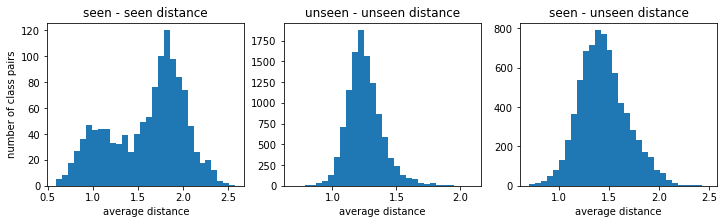

In [351]:
a = avg_distance[np.arange(50)][:,np.arange(50)]
a = a[np.where(a>0.0001)].flatten()
b = avg_distance[np.arange(start=50,stop=200)][:,np.arange(start=50,stop=200)]
b = b[np.where(b>0.001)].flatten()
c = avg_distance[np.arange(50)][:,np.arange(start=50,stop=200)]
c = c[np.where(c>0.00001)].flatten()

fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].hist(a,bins=30)
ax[0].set_title('seen - seen distance')
ax[0].set_xlabel('average distance')
ax[0].set_ylabel('number of class pairs')
ax[1].hist(b,bins=30)
ax[1].set_title('unseen - unseen distance')
ax[1].set_xlabel('average distance')
ax[2].hist(c,bins=30)
ax[2].set_title('seen - unseen distance')
ax[2].set_xlabel('average distance')

In [354]:
len(a[np.where(a<1)])/len(a)

0.12

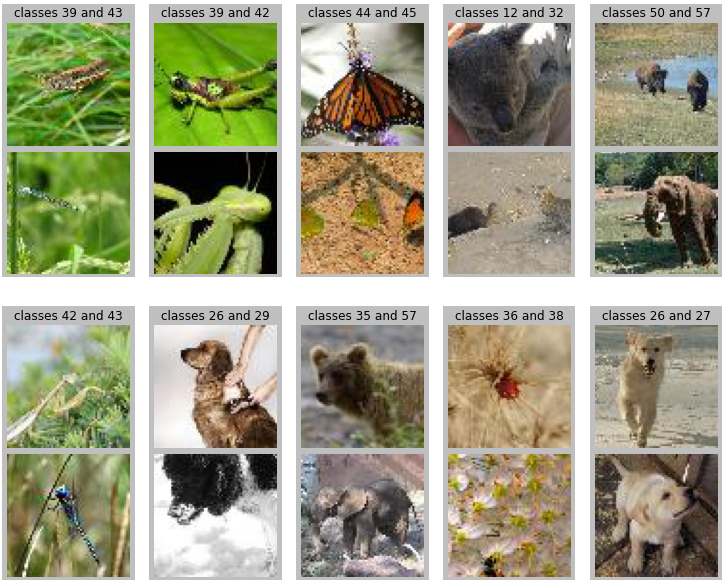

In [306]:
fig = plt.figure(constrained_layout=True, figsize=(10, 8))
subfigs = fig.subfigures(2, k//2, wspace=0.1,hspace=0.1)

for i in range(k):
    img1 = dataset.getImageFromClass(ind1[i])
    img2 = dataset.getImageFromClass(ind2[i])
    if i<k/2:
        ax0 =subfigs[0][i].add_subplot(211)
        ax1 = subfigs[0][i].add_subplot(212)
        subfigs[0][i].set_facecolor('0.75')
    else:
        ax0 =subfigs[1][i-k//2].add_subplot(211)
        ax1 = subfigs[1][i-k//2].add_subplot(212)
        subfigs[1][i-k//2].set_facecolor('0.75')
    ax0.imshow(img1)
    ax1.imshow(img2)
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_title('classes '+str(ind1[i])+' and '+str(ind2[i]))
    
    

([<matplotlib.axis.XTick at 0x230f8872620>,
 [Text(0, 0, '39 & 43'),
  Text(1, 0, '39 & 42'),
  Text(2, 0, '44 & 45'),
  Text(3, 0, '12 & 32'),
  Text(4, 0, '50 & 57'),
  Text(5, 0, '42 & 43'),
  Text(6, 0, '26 & 29'),
  Text(7, 0, '35 & 57'),
  Text(8, 0, '36 & 38'),
  Text(9, 0, '26 & 27')])

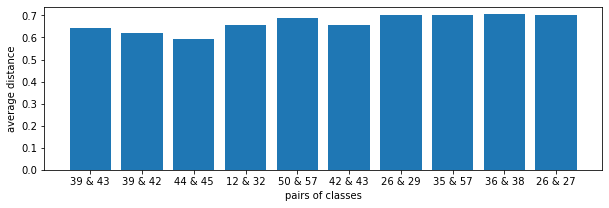

In [317]:
plt.figure(figsize=(10,3))
plt.bar(np.arange(k),similar)
plt.ylabel('average distance')
plt.xlabel('pairs of classes')
plt.xticks(np.arange(k),pairs)

In [279]:
subfigs[i]

array([<matplotlib.figure.SubFigure object at 0x0000022F8345A4D0>,
      dtype=object)

## Comparisson

In [134]:
import torch
models = ['mobilenet_testseen','mobilenet_testunseen','mobilenet_testall']
#models = ['simple','resnet','mobilenet']
#models = ['mobilenet','mobilenet_emb','mobilenetbinary','mobilenet_triple_emb']
#models = ['mobilenet_emb10','mobilenet','mobilenet_emb40']
#models = ['mobilenet_010','mobilenet_025','mobilenet','mobilenet_075']
roc = []
roc = []
accs = []
f1 = []
precision = []
for modelname in models:
    roc.append([torch.load("saved\\"+modelname+"_sensitivity.pkl"),torch.load("saved\\"+modelname+"_specificity.pkl")])
    accs.append(torch.load("saved\\"+modelname+"_accs.pkl"))
    f1.append(torch.load("saved\\"+modelname+"_f1.pkl"))
    precision.append(torch.load("saved\\"+modelname+"_precision.pkl"))

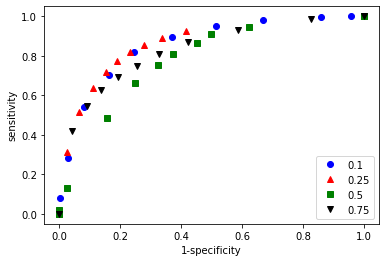

In [131]:
import matplotlib.pyplot as plt
shapes = ['bo','r^','gs','kv']
plt.figure()
for i in range(len(roc)):
    plt.plot(1-roc[i][1],roc[i][0],shapes[i])
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.legend(models)
plt.legend(['0.1','0.25','0.5','0.75'])

In [132]:
#threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=11)
threshs = np.linspace(start=0,stop=1,num=11)

In [136]:

for i in range(len(roc)):
    #ind = np.argmax(accs[i])
    ind=6
    print("{:.4f} & {:.4f} & {:.4f} & {:.4f}\\\\".format(accs[i][ind],precision[i][ind],roc[i][0][ind],f1[i][ind]))

0.8062 & 0.7877 & 0.8405 & 0.8133\\
0.5778 & 0.5672 & 0.6343 & 0.5989\\
0.6416 & 0.6331 & 0.6859 & 0.6584\\


In [96]:
mf1 = []
for i in range(len(roc)):
    ind = np.argmax(f1[i])
    mf1.append(f1[i][ind])
    print("{:.4f} & {:.4f} & {:.4f} & {:.4f}\\\\".format(accs[i][ind],precision[i][ind],roc[i][0][ind],f1[i][ind]))

0.7657 & 0.7186 & 0.8730 & 0.7883\\
0.7670 & 0.7205 & 0.8957 & 0.7986\\
0.7740 & 0.7505 & 0.8299 & 0.7882\\
